In [624]:
import os
from typing import Union
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import openfoamparser_mai as Ofpp

from scipy.interpolate import griddata

PathLike = Union[str, os.PathLike]

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [625]:
def max_timestep(simulation: PathLike) -> PathLike:
    timestep = str(max(map(lambda x: int(x) if x.isdigit() else -1, os.listdir(simulation))))
    return os.path.join(simulation, timestep)


def read_mesh_centers(simulation: PathLike):
    timestep = max_timestep(simulation)
    Cx = Ofpp.parse_internal_field(os.path.join(timestep, 'Cx'))
    Cy = Ofpp.parse_internal_field(os.path.join(timestep, 'Cy'))
    Cz = Ofpp.parse_internal_field(os.path.join(timestep, 'Cz'))
    return np.dstack((Cx, Cy, Cz))[0]


def read_speed_vector_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    U = Ofpp.parse_internal_field(os.path.join(timestep, 'U'))
    return U


def read_pressure_field(simulation: PathLike):
    timestep = max_timestep(simulation)
    p = Ofpp.parse_internal_field(os.path.join(timestep, 'p'))
    return p


In [626]:
def resize(a):
    return a[:,:-1]

In [627]:
x = np.array([1,2])

In [628]:
np.norm

AttributeError: module 'numpy' has no attribute 'norm'

(640, 2)
(640, 2)
(16128, 2)
(16128, 2)


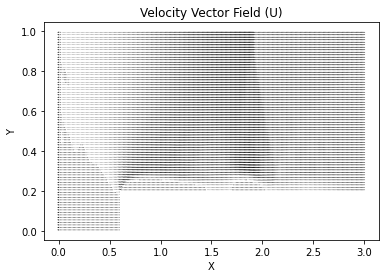

In [671]:

path_to_data_high = './data_step/high_dim'
path_to_data_low = './data_step/low_dim'
simulation_name = 'vel1.0'
saveOutput = 1


simulation_low = os.path.join(path_to_data_low, simulation_name)
simulation_high = os.path.join(path_to_data_high, simulation_name)

C_low = read_mesh_centers(simulation_low)
U_low = read_speed_vector_field(simulation_low)
p_low = read_pressure_field(simulation_low)

C_high = read_mesh_centers(simulation_high)
U_high= read_speed_vector_field(simulation_high)
p_high = read_pressure_field(simulation_high)

C_low = resize(C_low)
print(C_low.shape)
U_low = resize(U_low)
print(U_low.shape)
C_high = resize(C_high)
U_high = resize(U_high)
print(C_high.shape)
print(U_high.shape)
fig, ax = plt.subplots()
ax.quiver(C_high[:, 0], C_high[:, 1], U_high[:, 0], U_high[:, 1])
#ax.quiver(C_low[:, 0], C_low[:, 1], U_low[:, 0], U_low[:, 1])
# Add labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Velocity Vector Field (U)")

# Display the plot
plt.savefig(f"high_field.png")

In [672]:
data_low = np.concatenate((C_low,U_low), axis=1)
data_high = np.concatenate((C_high,U_high), axis=1)
data_low.shape
data_high.shape

(16128, 4)

In [673]:
data_low[:,2:4]

array([[-8.53587e-01,  1.09756e-03],
       [ 1.82467e-01,  5.25345e-04],
       [ 4.90298e-01,  3.23678e-03],
       ...,
       [ 1.13519e+00, -3.11271e-03],
       [ 1.13381e+00, -2.71636e-03],
       [ 1.12311e+00,  3.86860e-03]])

In [674]:
data_low = np.concatenate((data_low, p_low.reshape(-1,1)),axis = 1)
data_high = np.concatenate((data_high, p_high.reshape(-1,1)),axis = 1)

In [675]:
data_low[0:32].shape

(32, 5)

In [676]:
data_low = torch.Tensor(data_low, device=device)
data_high= torch.Tensor(data_high, device=device)
data_low.shape

torch.Size([640, 5])

In [677]:
data_high.reshape(-1, 5).shape

torch.Size([16128, 5])

In [678]:
# Assuming the original tensor is called 'data'

def res(data):
    # Create x and y coordinate meshgrids
    y_coords, x_coords = torch.meshgrid(torch.arange(data.size(2)), torch.arange(data.size(3)))

    # Flatten x and y coordinate tensors
    x_flat = x_coords.flatten().float()
    y_flat = y_coords.flatten().float()

    # Flatten original data tensor
    data_flat = data.view(3, -1).permute(1, 0)

    # Stack the flattened tensors to form the desired shape
    result = torch.stack((x_flat, y_flat, data_flat[:, 0], data_flat[:, 1], data_flat[:, 2]), dim=1)
    return result

In [679]:
import deepxde as dde
from IPython.display import clear_output
import seaborn as sns
from tqdm import trange

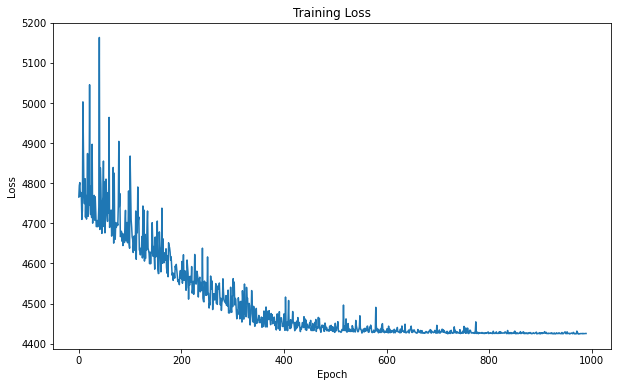

 99%|█████████▉| 991/1000 [04:14<00:02,  3.12it/s]

Epoch: 991/1000, Loss: 4425.462890625


100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


In [680]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# Define the Anisotropic Diffusion Model
class AnisotropicDiffusion(nn.Module):
    def __init__(self, time_step=0.01, iterations=100):
        super(AnisotropicDiffusion, self).__init__()
        self.time_step = time_step
        self.iterations = iterations
        self.diffusion_kernel = nn.Parameter(torch.randn(1, 3, 3, 3))
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.arc = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
)

      
    def forward(self, input_data):
        # Convert input_data to a 2D grid
        input_grid = torch.zeros(1, 3, 252, 64, device=input_data.device)
        x = input_data[:, 0]
        x = (x - x.min()) / (x.max() - x.min()) * 252 - 0.0001
        y = input_data[:, 1]
        y = (y - y.min()) / (y.max() - y.min()) * 64 - 0.0001
        x = x.long()
        y = y.long()
        values = input_data[:, 2:] # (v_x vy, p)
        input_grid[0, 0].scatter_(1, x[0].view(-1, 1), values[0, 0].view(-1, 1))
        input_grid[0, 1].scatter_(1, y[0].view(-1, 1), values[0, 1].view(-1, 1))
        #print(input_grid.shape)
        # Convert input_grid to the correct shape
        input_grid = input_grid.transpose(1, 2).transpose(2, 3)
        input_grid = input_grid.reshape(-1, 3, 252, 64)
        #print(input_grid.shape)
        # Apply diffusion
        velocity_field = input_grid.clone()
        velocity_field = self.arc(velocity_field)

        velocity_field = self.conv1(velocity_field)
        velocity_field = self.relu(velocity_field)
        for _ in range(self.iterations):
            gradient = nn.functional.conv2d(velocity_field, self.diffusion_kernel, padding=1)
            #print(gradient.shape)
            diffused = velocity_field + self.time_step * gradient
            velocity_field = diffused

        
        
        return velocity_field
# Instantiate the model
model = AnisotropicDiffusion()

# Define a loss function and an optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training function
def train_model(model, low_res_data, reference_high_res_data, epochs, batch_size):
    losses = []
    for epoch in trange(epochs):
        optimizer.zero_grad()
        high_res_field = model(low_res_data)
        #print(high_res_field.shape)
        loss = loss_function(res(high_res_field), reference_high_res_data)
        loss.backward()
        if epoch  != 0:
            losses.append(loss.item())

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=10, norm_type=2.0)
        optimizer.step()
        if epoch % 10 == 0:
            clear_output('True')
            plt.figure(figsize=(10, 6))
            sns.lineplot(x=range(len(losses)), y=losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss}')

# Train the model
train_model(model, data_low, data_high, epochs=1000, batch_size=32)

In [ ]:
y_pred = model(data_low)
y_pred.shape

torch.Size([1, 3, 252, 64])

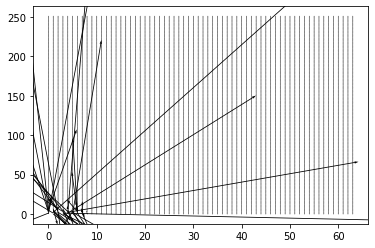

In [576]:
import matplotlib.pyplot as plt
import numpy as np

# assuming velocity_field is a torch tensor with shape (1, 3, 252, 64) and the first 2 channels are vx and vy

# get the velocity in the x-direction
vx =y_pred[0, 0].detach().cpu().numpy()

# get the velocity in the y-direction
vy = y_pred[0, 1].detach().cpu().numpy()

# create x and y grids for the quiver plot
x, y = np.meshgrid(np.arange(0, 64), np.arange(0, 252))

# plot the velocity field
fig, ax = plt.subplots()
ax.quiver(x, y, vx, vy)
plt.show()

In [577]:
v = y_pred[0,0:2 , :, :].view(-1, 2)
U_high[0:2]

array([[-1.45176e+00,  7.53784e-04],
       [-1.05534e-01,  6.66336e-04]])

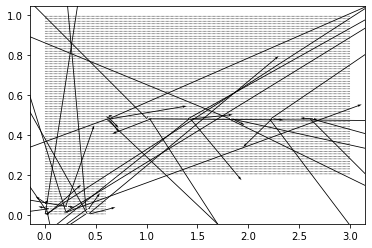

In [578]:
v = y_pred[0,0:2 , :, :].view(-1, 2)
p = y_pred[0, 2, :, :].reshape(-1, 1)
fig, ax = plt.subplots()
ax.quiver(C_high[:,0], C_high[:,1], v[:, 0].detach().numpy(), v[:, 1].detach().numpy())

torch.Size([16128, 1])

In [ ]:
low= []
for i in range(100):
    low.append('./data/low_dim/vel{}'.format(i+1))

high = []
for i in range(100):
    high.append('./data/hig_dim/vel{}'.format(i+1))

In [ ]:
C_high = read_mesh_centers(simulation_high)
U_high= read_speed_vector_field(simulation_high)
p_high = read_pressure_field(simulation_high)

C_high = resize(C_high)
U_high = resize(U_high)

In [286]:

# assume field is the tensor of size (1, 3, 252, 64)
field = torch.randn(1, 3, 252, 64)

# extract v_x component and reshape it to (12940, 1)
v_x = field[0, 0, :, :].reshape(-1, 1)

print(v_x.shape)  # should print (12940, 1)

torch.Size([16128, 1])
